In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
import string
classes = tuple(x for x in "_" + string.ascii_lowercase)

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

batch_size = 4

trainset = torchvision.datasets.EMNIST(root='./data', train=True,
                                        download=True, transform=transform, split="letters")
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.EMNIST(root='./data', train=False,
                                       download=True, transform=transform, split="letters")
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


100.0%


Extracting ./data\EMNIST\raw\gzip.zip to ./data\EMNIST\raw


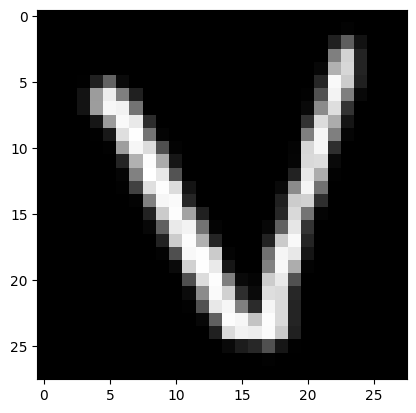

v    , tensor([22,  8,  9, 18])


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.rot90(npimg,3)
    npimg = np.fliplr(npimg)
    plt.imshow(npimg, cmap='gray')
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(images[0][0])
# print labels
print(f'{classes[labels[0]]:5s}, {labels}')

In [5]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(labels)

tensor([ 2, 11, 19, 14])


In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 27)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [7]:
import torchsummary 

torchsummary.summary(net, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
         MaxPool2d-2            [-1, 6, 12, 12]               0
            Conv2d-3             [-1, 16, 8, 8]           2,416
         MaxPool2d-4             [-1, 16, 4, 4]               0
            Linear-5                  [-1, 120]          30,840
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 27]           2,295
Total params: 45,871
Trainable params: 45,871
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.17
Estimated Total Size (MB): 0.22
----------------------------------------------------------------


In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [11]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.351
[1,  4000] loss: 0.607
[1,  6000] loss: 0.511
[1,  8000] loss: 0.485
[1, 10000] loss: 0.424
[1, 12000] loss: 0.388
[1, 14000] loss: 0.371
[1, 16000] loss: 0.349
[1, 18000] loss: 0.350
[1, 20000] loss: 0.342
[1, 22000] loss: 0.327
[1, 24000] loss: 0.315
[1, 26000] loss: 0.308
[1, 28000] loss: 0.297
[1, 30000] loss: 0.304
[2,  2000] loss: 0.276
[2,  4000] loss: 0.291
[2,  6000] loss: 0.285
[2,  8000] loss: 0.274
[2, 10000] loss: 0.254
[2, 12000] loss: 0.267
[2, 14000] loss: 0.262
[2, 16000] loss: 0.270
[2, 18000] loss: 0.279
[2, 20000] loss: 0.256
[2, 22000] loss: 0.272
[2, 24000] loss: 0.261
[2, 26000] loss: 0.274
[2, 28000] loss: 0.261
[2, 30000] loss: 0.271
Finished Training


In [10]:
PATH = '../cifar_net.pth'
# torch.save(net.state_dict(), PATH)

In [18]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
#imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

GroundTruth:  b     b     b     b    


In [11]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [12]:
outputs = net(images)

In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  b     k     s     n    


In [14]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

KeyboardInterrupt: 

In [78]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / (total_pred[classname]+ 0.00000000000001)
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: _     is 0.0 %
Accuracy for class: a     is 92.9 %
Accuracy for class: b     is 95.4 %
Accuracy for class: c     is 96.6 %
Accuracy for class: d     is 91.5 %
Accuracy for class: e     is 93.9 %
Accuracy for class: f     is 95.9 %
Accuracy for class: g     is 76.0 %
Accuracy for class: h     is 96.5 %
Accuracy for class: i     is 64.1 %
Accuracy for class: j     is 92.4 %
Accuracy for class: k     is 95.6 %
Accuracy for class: l     is 82.0 %
Accuracy for class: m     is 97.9 %
Accuracy for class: n     is 86.1 %
Accuracy for class: o     is 95.1 %
Accuracy for class: p     is 96.0 %
Accuracy for class: q     is 82.1 %
Accuracy for class: r     is 92.6 %
Accuracy for class: s     is 96.8 %
Accuracy for class: t     is 92.6 %
Accuracy for class: u     is 92.0 %
Accuracy for class: v     is 90.5 %
Accuracy for class: w     is 94.9 %
Accuracy for class: x     is 95.2 %
Accuracy for class: y     is 79.0 %
Accuracy for class: z     is 97.4 %


(28, 28)


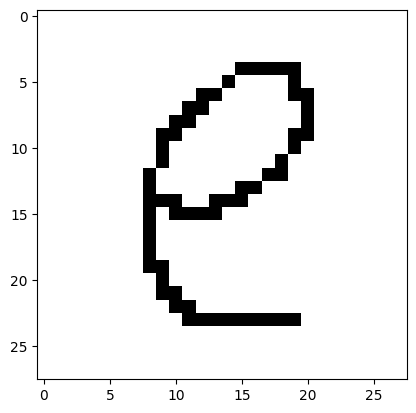

torch.Size([1, 28, 28])
tensor([[6.3075e-08, 1.6089e-01, 1.7576e-01, 3.4269e-03, 4.5166e-03, 2.9940e-02,
         2.1659e-02, 6.2856e-02, 8.5832e-03, 2.7537e-04, 1.9538e-03, 1.7174e-02,
         3.4450e-03, 9.2474e-03, 1.0047e-02, 4.5950e-03, 5.8402e-02, 1.8500e-01,
         2.0080e-01, 1.9804e-02, 1.3587e-03, 2.3158e-03, 1.7115e-04, 1.8428e-03,
         4.4580e-03, 1.0385e-03, 1.0443e-02]], grad_fn=<SoftmaxBackward0>)
r    


In [67]:
from PIL import Image
import torchvision.transforms.functional as TF

image = Image.open("examples/demo/e.png")
image = image.convert("1")
x = TF.to_tensor(image).squeeze()
x = x.numpy()
print(x.shape)
x = np.fliplr(x)
x = np.rot90(x)

x = torch.from_numpy(x.copy())
imshow(x)
x = x.unsqueeze(0)
print(x.shape)

output = net(x.unsqueeze(0))
output = torch.softmax(output, 1)
print(output)
output = torch.argmax(output)
print(f'{classes[output]:5s}') 